In [22]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import h5py
import sys
%matplotlib inline 

In [23]:
be = h5py.File('variables_tt_re.h5','r')
bmu = h5py.File('variables_tt_rmu.h5','r')
be1 = h5py.File('variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [27]:
input_keysJ = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r']
input_keysL = ['lep_pt', 'lep_eta', 'lep_phi', 'lep_m', 'met_met', 'met_phi']
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']

In [28]:
# Convert into numpy arrays and mean normalize
crop =  len(dataset.get('j1_pt'))//4

input_arraysJ = []
input_arraysL = []
output_arrays = [] 

def create_variables(keys, output):
    for key in keys:
        exec(key + ' = np.array(dataset.get(key))[0:crop].reshape((1,-1))')
        exec('{0} = ({0} - np.mean({0}))/np.std({0})'.format(key))
        exec('output.append({0})'.format(key))
    
create_variables(input_keysJ, input_arraysJ)
create_variables(input_keysL, input_arraysL)
create_variables(output_keys, output_arrays)

In [29]:
# Create input and test array
split = int(np.floor(0.9*crop)) # 80/20 split 
shuffle = True
    
total_inputJ = np.stack(input_arraysJ).reshape((crop, len(input_keysJ)))
total_inputL = np.stack(input_arraysL).reshape((crop, len(input_keysL)))
total_output = np.stack(output_arrays).reshape((crop, len(output_keys)))

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_inputJ)
    np.random.set_state(rng_state)
    np.random.shuffle(total_inputL)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)
    
# size = total_input.shape
# total_input = np.array(np.random.normal(size=total_input.shape))

train_inputJ, test_inputJ = total_inputJ[0:split, :], total_inputJ[split:, :]
train_inputL, test_inputL = total_inputL[0:split, :], total_inputL[split:, :]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [30]:
print(train_inputJ.shape, test_inputJ.shape)
print(train_inputL.shape, test_inputL.shape)
print(train_output.shape, test_output.shape)

(981195, 40) (109022, 40)
(981195, 6) (109022, 6)
(981195, 6) (109022, 6)


In [12]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

def build_model():
    model = keras.Sequential([
        layers.LSTM(64,input_shape=[len(input_keys)]),
        layers.Dense(6, activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [13]:
model = build_model()
model.summary()

TypeError: __init__() missing 1 required positional argument: 'output_dim'

In [10]:
# Fit model

Epochs= 16

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, 
                   batch_size=1000)


Train on 784956 samples, validate on 196239 samples
Epoch 1/16
  1000/784956 [..............................] - ETA: 35:39

InvalidArgumentError:  indices[282,1] = -2 is not in [0, 46)
	 [[node sequential/embedding/embedding_lookup (defined at <ipython-input-10-72e6f42a5ca8>:7) ]] [Op:__inference_distributed_function_3035]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/embedding/embedding_lookup:
 sequential/embedding/embedding_lookup/1932 (defined at /home/hongtao/anaconda3/envs/top-ml/lib/python3.7/contextlib.py:112)

Function call stack:
distributed_function


In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [12]:
predictions = model.predict(test_input)

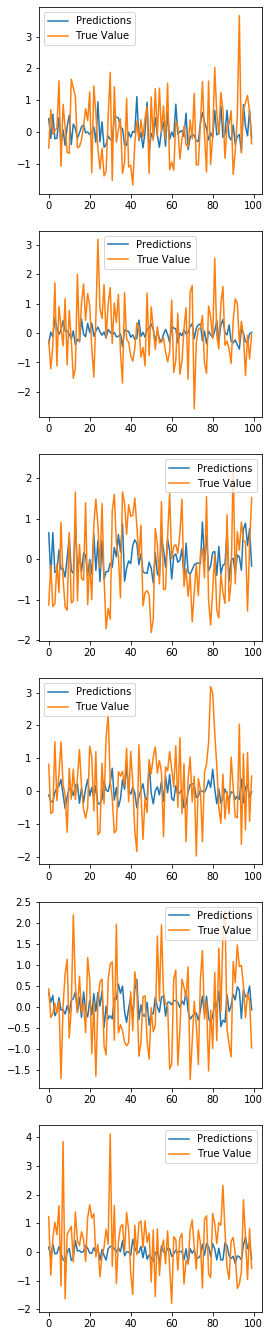

In [13]:
train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

plt.figure(figsize=(4,24))
for i in range(0,6):
    plt.subplot(6,1,i+1)
    plt.plot(train_small[:,i],label = 'Predictions')
    plt.plot(output_small[:,i],label = 'True Value')
    plt.legend()

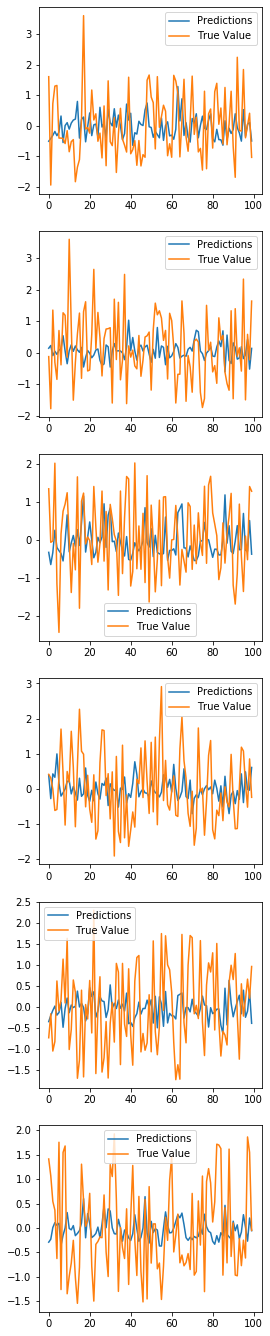

In [14]:
predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

plt.figure(figsize=(4,24))
for i in range(0,6):
    plt.subplot(6,1,i+1)
    plt.plot(predictions_small[:,i],label = 'Predictions')
    plt.plot(test_output_small[:,i],label = 'True Value')
    plt.legend()
    